<a href="https://colab.research.google.com/github/MatiasCovarrubias/econjax/blob/main/VFI_using_JAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parallelized Value Function Iteration Using JAX

This colab notebook explores ideas on how to optimally use JAX to perdorm value funciton iteration. The objective is to improve on https://notes.quantecon.org/submission/622ed4daf57192000f918c61 . Hypothetically, we can get better performance by using vmap, making all the fuctions pure, using lax.scan for iterations and using the most optimal jax functions.

The problem is to maximize the expected discounted sum

$$ 𝔼\sum_{t≥0} β^t u(c_t)$$

subject to

$$c_t+a_t+1≤Ra_t+yt, \quad c_t≥0,\quad a_t≥0$$

for all $t≥0$, with $a_0$ and $y_0$ given. Here $c_t$ is consumption, $a_t$ is assets, $R$ is the gross risk-free rate of return, and $y_t$ is income. The income process follows a Markov chain with transition matrix $P$.

The Bellman equation is

$$v(a,y)= \underset{0≤a′≤Ra+y}{\max} \{ u(Ra+y−a′)+β\sum_{y′}v(a′,y′)P(y,y′) \}$$

where $v$ is the value function. The corresponding Bellman operator is

$$Tv(a,y)= \underset{0≤a′≤Ra+y}{\max} \{ u(Ra+y−a′)+β\sum_{y′}v(a′,y′)P(y,y′) \}$$

We solve the dynamic program by value function iteration --- that is, by iterating with T.


We will start by installing quantecon and importing the libraries we will use

In [ ]:
# installs
!pip install -U quantecon # Install quantecon in case it's missing

#imports
import numpy as np
import jax
import jax.numpy as jnp
from numba import njit
import quantecon as qe 
import matplotlib.pyplot as plt
import timeit
from jax.config import config
config.update("jax_log_compiles", 1)
# to suppress watnings uncomment next two lines
# import warnings
# warnings.filterwarnings('ignore')

     |████████████████████████████████| 179 kB 16.4 MB/s 


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


# Starting Point: Naive implementation on a small grid

Next, we specify global parameters (we will then move it to local), the grids for the state and actions, and the inital value for the value function. 

In [ ]:
R = 1.1
β = 0.99
γ = 2.5

# grid for assets
a_min, a_max = 0.01, 2
a_size = ap_size = 128
a_grid = np.linspace(a_min, a_max, a_size)  # grid for a
ap_grid = np.linspace(a_min, a_max, a_size)                 # grid for a'

#grid for y (use QuantEcon's tauchen() function to create Markov Chains out of AR(1))
ρ = 0.9
σ = 0.1
y_size = 8
mc = qe.tauchen(ρ, σ, n=y_size)
y_grid = np.exp(mc.state_values)
P = np.array(mc.P)
print("state size:", a_size*y_size)

# initial value
v_init = np.zeros((a_size, y_size))

state size: 1024


We are going to start by using a nainve approach that uses for loops extensively. This structure is going t o be the base of our "authomatically vectorized" version.

In [ ]:
def u(c):
    return c**(1-γ) / (1-γ)

def T_naive(v):
    "The Bellman operator."
    # Allocate memory
    v_new = np.empty_like(v)
    # Step through all states
    for i, a in enumerate(a_grid):
        for j, y in enumerate(y_grid):
            # Choose a' optimally by stepping through all possible values
            v_max = - np.inf
            for k, ap in enumerate(ap_grid):
                c = R * a + y - ap
                if c > 0:  
                    # Calculate the right hand side of the Belllman operator
                    val = u(c) + β * np.dot(v[k, :], P[j, :])
                    if val > v_max:
                        v_max = val
            v_new[i, j] = v_max
    return v_new

%time T_naive(v_init)


CPU times: user 457 ms, sys: 11.9 ms, total: 469 ms
Wall time: 458 ms


array([[-1.86623555, -1.39026198, -1.03558477, ..., -0.42783137,
        -0.3186092 , -0.2372622 ],
       [-1.77434107, -1.33358887, -1.00068349, ..., -0.41973168,
        -0.31363942, -0.23421456],
       [-1.68974815, -1.28066418, -0.96769951, ..., -0.41188438,
        -0.3087975 , -0.2312316 ],
       ...,
       [-0.15384391, -0.14482871, -0.13498711, ..., -0.10187474,
        -0.09033787, -0.07897758],
       [-0.1523595 , -0.143486  , -0.13379257, ..., -0.1011265 ,
        -0.08972517, -0.0784876 ],
       [-0.15089881, -0.14216391, -0.13261555, ..., -0.10038738,
        -0.08911936, -0.07800266]])

# Second pass: vectorized solution on large grid using JAX and accelerators

 First, let's check that Google Colab has assigned us a nice GPU.

If we want to use TPUs, set use_TPU = True in the next cel. If not, the code !nvidia-smi will tell us what GPU has been asigned to us.

In [ ]:
use_TPU = False
if use_TPU:
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()
else:
  !nvidia-smi

Thu May 12 02:38:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In the case you chose a GPU runtime, if you don't use Colab Pro, you should get something lika a Tesla K80. Since I am using Colab Pro, I got a Tesla P100.

Now we are going to redefine de grids using jax.numpy arrays and we are going to increase the size of the grid.

In [ ]:
# grid for assets
scale=4
a_size = ap_size = 1028*scale
a_grid = jnp.linspace(a_min, a_max, a_size)  # grid for a
ap_grid = jnp.linspace(a_min, a_max, a_size)                 # grid for a'

#grid for y (use QuantEcon's tauchen() function to create Markov Chains out of AR(1))
ρ = 0.9
σ = 0.1
y_size = 128*scale
mc = qe.tauchen(ρ, σ, n=y_size)
y_grid = jnp.exp(mc.state_values)
P = jnp.array(mc.P)
print("state size:", a_size*y_size)

# initial value
v_init = jnp.zeros((a_size, y_size))

state size: 2105344


## Manual vectorization: Reshape grids and transition matrix


We add dimensions to arrays so that they will be stretched along the new dimensions when placed in arithmetic operations with other arrays that have more elements along those dimensions. This stretching is done by repeating values, which is what we use to replace loops.

The next code cell reshapes all arrays to be three-dimensional.

In [ ]:
P = jnp.reshape(P, (y_size, y_size, 1))
a = jnp.reshape(a_grid, (a_size, 1, 1))
y = jnp.reshape(y_grid, (1, y_size, 1))
ap = jnp.reshape(ap_grid, (1, 1, ap_size))

Now we can implement a vectorized version of the Bellman operator, which calculates the same values.

In [ ]:
def u(c):
    return c**(1-γ) / (1-γ)

def T_manualvec(v):
    vp = jnp.dot(v, P) # vp has shape (a_size, y_size, 1)
    c = R * a + y - ap # c has shape (a_size, y_size, ap_size)
    # m = jnp.where(c > 0, u(c) + β * vp, -np.inf) # m has shape (a_size, y_size, ap_size) 
    m = u(c) + β * vp # m has shape (a_size, y_size, ap_size) 
    return jnp.max(m, axis=2) # we to average over the last axis, that is, for each a and y, get the the max over ap.


Now wer are gonig to precompile the T operation so JAX optimize it use of the hardware.

In [ ]:
T_manualvec_jit = jax.jit(T_manualvec).lower(v_init).compile()
%time T_manualvec_jit(v_init).block_until_ready()

CPU times: user 208 ms, sys: 0 ns, total: 208 ms
Wall time: 385 ms


DeviceArray([[        nan,         nan,         nan, ...,         nan,
                      nan, -0.23726219],
             [        nan,         nan,         nan, ...,         nan,
                      nan, -0.23716709],
             [        nan,         nan,         nan, ...,         nan,
                      nan, -0.23707198],
             ...,
             [-0.15098839, -0.1508744 , -0.15076025, ..., -0.07833294,
              -0.07818268, -0.07803249],
             [-0.15094359, -0.15082967, -0.15071559, ..., -0.07831794,
              -0.07816772, -0.07801757],
             [-0.15089881, -0.15078494, -0.15067092, ..., -0.07830293,
              -0.07815276, -0.07800266]], dtype=float32)

With a Tesla P100 GPU, we get 30ms. With TPU, we get 16.9

## Authomatic vecotrization using vmap

To start, we are going to save all the parts we need in a model dictionary to have pure functions

In [ ]:
# We are going to store the structure of the model in a dictionary
grids = {
    "a": a_grid,
    "y": y_grid,
    "ap": ap_grid,}

params = {
    "R": 1.1,
    "beta": 0.99,
    "gamma": 2.5
}

model = {"params": params, 
         "grids": grids, 
         "Trans_matrix": P, 
         "indices": {"a": jnp.array(range(a_size)), "y": jnp.array(range(y_size)), "ap": jnp.array(range(ap_size))}}



When we calculate the value function at each point of the grid, we want to pass all the possible actions as a vector, and then calculate the maximum. In order to get the actio_value for all the possible actions, we are going to use vmap.

In [ ]:
def get_update_fn_autovec(model:dict):

  def v_update(v: jnp.ndarray):
    params = model["params"]
    grids = model["grids"]
    P = model["Trans_matrix"]
    def action_v(a_ind: int, y_ind: int, ap_ind: int, v: jnp.array):
      c = params["R"]*grids["a"][a_ind]+grids["y"][y_ind]-grids["ap"][ap_ind]
      # 
      return jnp.where(c>0, c**(1-params["gamma"]) / (1-params["gamma"]) + params["beta"] * jnp.dot(v[ap_ind,:],P[y_ind, :]) ,- jnp.inf)
    # first vmap to calculate action value for all possible ap's.
    vmapped_action_v = jax.vmap(action_v, in_axes=(None,None,0, None))
    # get the maximum of all action_values for a pair of (a,y)
    def one_state_v(a_ind: int, y_ind: int, ap_grid: jnp.array, v: jnp.array):
      return jnp.max(vmapped_action_v(a_ind, y_ind, ap_grid, v))

    # do vmaps over the other two dimensions.
    all_state_v = jax.vmap(jax.vmap(one_state_v, in_axes=(None,0,None, None)), in_axes=(0,None,None, None))
    #calculate value fuction matrix
    a_indices = model["indices"]["a"]
    y_indices = model["indices"]["y"]
    ap_indices = model["indices"]["ap"]
    new_state_value = all_state_v(a_indices,y_indices,ap_indices, v)
    return new_state_value

  return v_update

In [ ]:
T_autovec = get_update_fn_autovec(model)
T_autovec_jit = jax.jit(T_autovec).lower(v_init).compile()

In [ ]:
%time T_autovec_jit(v_init).block_until_ready()

CPU times: user 3.85 ms, sys: 867 µs, total: 4.71 ms
Wall time: 431 ms


DeviceArray([[-1.8662355 , -1.858725  , -1.8512443 , ..., -0.23918638,
              -0.23822235, -0.23726219],
             [-1.8632786 , -1.8557878 , -1.848327  , ..., -0.23908995,
              -0.23812656, -0.23716709],
             [-1.8603299 , -1.8528588 , -1.8454175 , ..., -0.23899359,
              -0.23803085, -0.23707198],
             ...,
             [-0.15098839, -0.1508744 , -0.15076025, ..., -0.07833294,
              -0.07818268, -0.07803249],
             [-0.15094359, -0.15082967, -0.15071559, ..., -0.07831794,
              -0.07816772, -0.07801757],
             [-0.15089881, -0.15078494, -0.15067092, ..., -0.07830293,
              -0.07815276, -0.07800266]], dtype=float32)

To finish the exercise off, let's iterate until convergence.

In [ ]:
def vfi_iterator(v_init=v_init, tol=1e-6, max_iter=1435):
    error = tol + 1
    i = 0
    v = v_init
    # while error > tol and i < max_iter:
    while i < max_iter:
        new_v = T_autovec_jit(v)
        error = jnp.max(jnp.abs(new_v - v))
        v = new_v

        if i % 100 == 0:
            print(f"Iteration {i}")
        i += 1

    if i == max_iter:
        print(f"Warning: iteration hit upper bound {max_iter}.")
    else:
        print(f"\nConverged at iteration {i}.")
    return v

%time v = vfi_iterator()

Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900
Iteration 1000
Iteration 1100
Iteration 1200
Iteration 1300
Iteration 1400
CPU times: user 17.3 s, sys: 1min 18s, total: 1min 35s
Wall time: 1min 33s


## Parallelizing across TPU cores using pmaps

We are going to make a very small change to our update funciton so we can give a partition of the grid of a as an input and we get can update the value function only on those states. Then, with pmap, we will vectorize that function so we give a n array with n_device partitions of a and it will update those partitions of the state in parallel across TPU_cores.

In [ ]:
def get_update_fn_tpu(model:dict):

  def v_update(a_partition:jnp.array, v: jnp.ndarray):
    params = model["params"]
    grids = model["grids"]
    P = model["Trans_matrix"]
    def action_v(a_ind: int, y_ind: int, ap_ind: int, v: jnp.array):
      c = params["R"]*grids["a"][a_ind]+grids["y"][y_ind]-grids["ap"][ap_ind]
      # 
      return jnp.where(c>0, c**(1-params["gamma"]) / (1-params["gamma"]) + params["beta"] * jnp.dot(v[ap_ind,:], model["Trans_matrix"][y_ind, :]) ,- jnp.inf)
    # first vmap to calculate action value for all possible ap's.
    vmapped_action_v = jax.vmap(action_v, in_axes=(None,None,0, None))
    # get the maximum of all action_values for a pair of (a,y)
    def one_state_v(a_ind: int, y_ind: int, ap_grid: jnp.array, v: jnp.array):
      return jnp.max(vmapped_action_v(a_ind, y_ind, ap_grid, v))

    # do vmaps over the other two dimensions.
    all_state_v = jax.vmap(jax.vmap(one_state_v, in_axes=(None,0,None, None)), in_axes=(0,None,None, None))
    #calculate value fuction matrix
    a_indices = a_partition
    y_indices = model["indices"]["y"]
    ap_indices = model["indices"]["ap"]
    new_state_value = all_state_v(a_indices,y_indices,ap_indices, v)
    return new_state_value

  return v_update

No, we create an array with the partitions. The dimension of that array should be (n_cores,a_size/n_cores), so the leading axis organize the different partitions.

In [ ]:
n_devices = jax.local_device_count()
a_partitions = jnp.reshape(model["indices"]["a"], (n_devices, a_size//n_devices))

Now we are goingh to pmap the function so instead of accepting a single partition of a as an input, it takes n array with partitions.

In [ ]:
T_tpu = get_update_fn_tpu(model)
T_tpu_jit = jax.pmap(T_tpu, in_axes = (0,None)).lower(a_partitions, v_init).compile()
%timeit -r 1 -n 10 T_tpu_jit(a_partitions,v_init).block_until_ready()

10 loops, best of 1: 18.5 ms per loop


We get a X2 increase in throughput vs the manually vectorized solution. 

In [ ]:
def vfi_iterator(v_init=v_init, tol=1e-6, max_iter=1435):
    error = tol + 1
    i = 0
    v = v_init
    while error > tol and i < max_iter:
    # while i < max_iter:
        new_v = T_tpu_jit(a_partitions,v).reshape(a_size,y_size)
        error = jnp.max(jnp.abs(new_v - v))
        v = new_v

        if i % 100 == 0:
            print(f"Iteration {i}")
        i += 1

    if i == max_iter:
        print(f"Warning: iteration hit upper bound {max_iter}.")
    else:
        print(f"\nConverged at iteration {i}.")
    return v

%time v = vfi_iterator()

Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600

Converged at iteration 601.
CPU times: user 27.6 s, sys: 39.4 s, total: 1min 6s
Wall time: 48 s


# Pre-compiling the entire experiment (not just the update)

In [ ]:
def get_learner_fn(model:dict, iterations):

  def v_update(v: jnp.ndarray, error):
    params = model["params"]
    grids = model["grids"]
    P = model["Trans_matrix"]
    def action_v(a_ind: int, y_ind: int, ap_ind: int, v: jnp.array):
      c = params["R"]*grids["a"][a_ind]+grids["y"][y_ind]-grids["ap"][ap_ind]
      # 
      return jnp.where(c>0, c**(1-params["gamma"]) / (1-params["gamma"]) + params["beta"] * jnp.dot(v[ap_ind,:], P[y_ind, :]) ,- jnp.inf)
    # first vmap to calculate action value for all possible ap's.
    vmapped_action_v = jax.vmap(action_v, in_axes=(None,None,0, None))
    # get the maximum of all action_values for a pair of (a,y)
    def one_state_v(a_ind: int, y_ind: int, ap_grid: jnp.array, v: jnp.array):
      return jnp.max(vmapped_action_v(a_ind, y_ind, ap_grid, v))

    # do vmaps over the other two dimensions.
    all_state_v = jax.vmap(jax.vmap(one_state_v, in_axes=(None,0,None, None)), in_axes=(0,None,None, None))
    #calculate value fuction matrix
    a_indices = model["indices"]["a"]
    y_indices = model["indices"]["y"]
    ap_indices = model["indices"]["ap"]
    new_v = all_state_v(a_indices,y_indices,ap_indices, v)
    new_error = jnp.max(jnp.abs(new_v - v))
    return new_v, new_error

  def learner_fn(v_init):  # repeat many times to avoid going back to Python.
    return jax.lax.scan(v_update, v_init, None, length = iterations)

  return learner_fn

In [ ]:
n_iters = 1435
learner_fn = get_learner_fn(model, n_iters)
jitted_learner_fn = jax.jit(learner_fn).lower(v_init).compile()

CPU times: user 15.7 s, sys: 1min 11s, total: 1min 27s
Wall time: 1min 24s


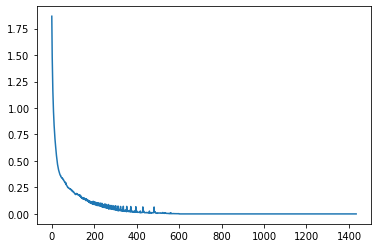

In [ ]:
%time value_final, error_stack = jitted_learner_fn(v_init)
plt.plot(range(n_iters),error_stack)

# Benchmarks

Now we are going to store our results for different levels of scales

In [ ]:
class TimeIt():

  def __init__(self, tag, frames=None):
    self.tag = tag
    self.frames = frames

  def __enter__(self):
    self.start = timeit.default_timer()
    return self

  def __exit__(self, *args):
    self.elapsed_secs = timeit.default_timer() - self.start
    msg = self.tag + (': Elapsed time=%.2fs' % self.elapsed_secs)
    if self.frames:
      msg += ', FPS=%.2e' % (self.frames / self.elapsed_secs)
    print(msg)

In [ ]:
results_dict = {"Size of grid": [], "Manual Vectorization": [], "Automatic Vectorization": [], "TPU Parallelization": []}
for scale in [1,2,4,8]:
  # grid for assets
  a_size = ap_size = 1024*scale
  a_grid = jnp.linspace(a_min, a_max, a_size)  # grid for a
  ap_grid = jnp.linspace(a_min, a_max, a_size)                 # grid for a'
  #grid for y (use QuantEcon's tauchen() function to create Markov Chains out of AR(1))
  ρ = 0.9
  σ = 0.1
  y_size = 128*scale
  mc = qe.tauchen(ρ, σ, n=y_size)
  y_grid = jnp.exp(mc.state_values)
  P = jnp.array(mc.P)
  results_dict["Size of grid"].append(a_size*y_size)

  grids = {
    "a": a_grid,
    "y": y_grid,
    "ap": ap_grid,}

  params = {
      "R": 1.1,
      "beta": 0.99,
      "gamma": 2.5
  }

  model = {"params": params, 
          "grids": grids, 
          "Trans_matrix": P, 
          "indices": {"a": jnp.array(range(a_size)), "y": jnp.array(range(y_size)), "ap": jnp.array(range(ap_size))}}


  # initial value
  v_init = jnp.zeros((a_size, y_size))
  P = jnp.reshape(P, (y_size, y_size, 1))
  a = jnp.reshape(a_grid, (a_size, 1, 1))
  y = jnp.reshape(y_grid, (1, y_size, 1))
  ap = jnp.reshape(ap_grid, (1, 1, ap_size))


  T_manualvec_jit = jax.jit(T_manualvec).lower(v_init).compile()
  T_autovec = get_update_fn_autovec(model)
  T_autovec_jit = jax.jit(T_autovec).lower(v_init).compile()

  if use_TPU:
    a_partitions = jnp.reshape(model["indices"]["a"], (n_devices, a_size//n_devices))
    T_tpu = get_update_fn_tpu(model)
    T_tpu_jit = jax.pmap(T_tpu, in_axes = (0,None)).lower(a_partitions, v_init).compile()
    results_dict["Manual Vectorization"].append(timeit.timeit('T_manualvec_jit(v_init).block_until_ready()', globals=globals(), number=100))
    results_dict["Automatic Vectorization"].append(timeit.timeit('T_autovec_jit(v_init).block_until_ready()', globals=globals(), number=100))
    results_dict["TPU Parallelization"].append(timeit.timeit('T_tpu_jit(a_partitions, v_init).block_until_ready()', globals=globals(), number=100))
  else:
    results_dict["Manual Vectorization"].append(timeit.timeit("T_manualvec_jit(v_init).block_until_ready()", globals=globals(), number=100))
    results_dict["Automatic Vectorization"].append(timeit.timeit('T_autovec_jit(v_init).block_until_ready()', globals=globals(), number=100))

print(results_dict)

it works


it works


it works


it works
{'Size of grid': [131072, 524288, 2097152, 8388608], 'Manual Vectorization': [0.37764132200004497, 2.5571336220000376, 19.766007327999887, 157.03423161800015], 'Automatic Vectorization': [0.4339618720000544, 3.02273190599999, 31.13093618799985, 237.56771815899992], 'TPU Parallelization': []}


 For TPU, we get {'Manual Vectorization': [0.30772871099907206, 1.4740470310025557, 9.87848552899959, 77.9623624650012], 'Automatic Vectorization': [0.3273367039982986, 1.5696243140009756, 12.601403237997147, 92.91537422500187], 'TPU Parallelization': [0.8347508730003028, 1.4450628260019585, 3.4721897010022076, 17.260116208999534]}

 For GPU{'Size of grid': [131072, 524288, 2097152, 8388608], 'Manual Vectorization': [0.37764132200004497, 2.5571336220000376, 19.766007327999887, 157.03423161800015], 'Automatic Vectorization': [0.4339618720000544, 3.02273190599999, 31.13093618799985, 237.56771815899992]}